Shear band analysis for Lemiale et al 2008 results
=====


This notebook takes the stress field resulting from the **Lemiale-Parallel** notebook and calculates the shear band angle from the stress field. A single example is provided to show the analysis. For more details see the accompanying **Lemiale-Parallel** notebook.



**Keywords:** particle swarms, Stokes system, advective diffusive systems, complex rheology, parallel analysis

**References**

1. V. Lemiale, H.-B. Mühlhaus, L. Moresi, and J. Stafford, Shear banding analysis of plastic models formulated for incompressible viscous flows. Physics of the Earth and Planetary Interiors (2008) 171: 177-186.
http://www.sciencedirect.com/science/article/pii/S0031920108001933


In [1]:
import numpy as np
import os
import underworld as uw
import glucifer
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab

Set parameters for pre-run data
-----

Data is provided for the compression case with $\tan \phi$ = 0.4, other valid parameter pairs used in Lemiale et al 2008 are:

* Extension: $\tan \phi$ = 0.0, 0.2, 0.4, 0.6 or 0.7
* Compression: $\tan \phi$ = 0.0, 0.2, 0.4, 0.6 or 0.8


In [2]:
tanPhi = 0.4
iExtension = False

**Set directory where data exists**

In [3]:
# As a precaution ... keep workdir. 
try:
    workdir
except NameError:
    workdir = os.path.abspath(".")
# check outputs directory exists, make it if it doesn't
outputPath = os.path.join(workdir,"outputData/")
if uw.rank() == 0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)    

In [4]:
txtTanPhi = str(int(tanPhi*10.)).zfill(1)

if(iExtension==True):
    inputPath = os.path.join(workdir,"data_ext/")
else:
    inputPath = os.path.join(workdir,"data_comp/")


**Set parameters for saved models**

In [5]:
# set resolution
resX = 384
resY = 128

if(iExtension==True):
    cinf = 3.95 # value used for provided extension runs
    cohesion = 4.
else:
    cinf = 10.0 # value used for provided compression runs
    cohesion = 20.

Create mesh and finite element variables
------

Note: the use of a pressure-sensitive rheology suggests that it is important to use a Q2/dQ1 element 

In [6]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( 0., 0.), 
                                 maxCoord    = ( 1., 1.),
                                 periodic    = [False, False]  ) 

meshDevStress = uw.mesh.MeshVariable( mesh, 1 )

Load mesh and stress values from saved files
-----

In [7]:
mesh.load(inputPath + "Mesh_" + txtTanPhi + ".h5")
meshDevStress.load(inputPath + "meshDevStress_" + txtTanPhi + ".h5")

Plot deviatoric stress
----


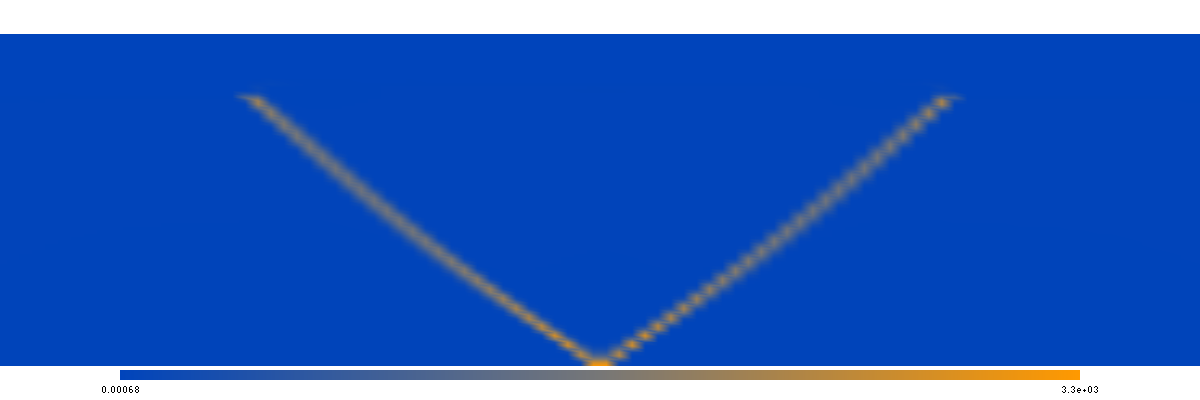

In [8]:
maxWidth=1.
figMeshStress = glucifer.Figure( figsize=(1200,400), boundingBox=((-maxWidth, 0.0, 0.0), (maxWidth, 1.0, 0.0)) )
figMeshStress.append( glucifer.objects.Surface(mesh, meshDevStress  , colours="#0044BB, #777777, #FF9900") )
figMeshStress.show()

Post-analysis: Shear band angle calculation
----

Calculate the angle the shear band makes to the vertical direction. This is clearest to see in the second invariant of the deviatoric stress tensor.

The deviatoric stress tensor needs to be known near the weak point at the centre, bottom on the simulation domain. As this simulation is (most likely) done in parallel then not all information needed near the weak point is known to any single processor. 

Therefore we must determine the shear band angle by 

1. first collecting all data from all processors, easiest way to do this is to save the variable of interest and the mesh it exists on. 
2. create new mesh which is **not** partitioned. This means each processor sees the entire mesh.
3. create a new variable and load the previously stored data onto it.
4. use the new variable for analysis on a single processor.

**Conduct analysis on the first processor only**

Output to screen and to a summary text file.

In [9]:
radius = 0.2
nbin = 100
theta = np.arange(0.,np.pi/2.0, np.pi/(2.*float(nbin)))
fdev = np.zeros(nbin)
xx = np.zeros(nbin)
yy = np.zeros(nbin)
fmax = 0.0
for i in range(nbin):
    xx[i] = radius*np.cos(np.pi/2.0 - theta[i])
    yy[i] = radius*np.sin(np.pi/2.0 - theta[i])
positions = np.zeros((nbin,2))
for i in range(nbin):
    positions[i][0]=xx[i]
    positions[i][1]=yy[i]

# global evaluations must be written so all processors go through this part
#    (only rank=0 needs the correct info for the call though)
fdev = meshDevStress.evaluate_global( positions )

# back to rank=0 analysis
if uw.rank()==0: 
    for i in range(nbin):
        if(fmax<fdev[i]):
            fmax = fdev[i]
            thetamax = theta[i]
    if(iExtension):
        print('Extension model parameters:')
    else:
        print('Compression model parameters:')
    thetaDeg = thetamax*180./np.pi
    print('Res = {0:3d}*{1:3d}; C0 = {2:.1f}; Cinf = {3:.2f}'.format(resX, resY, cohesion, cinf))
    print('tan(phi) = {0:.1f}; theta = {1:.1f}'.format(tanPhi, thetaDeg))
    f = open('summary.out','w')
    f.write('{0:3d} {1:3d} {2:.1f} {3:.2f} {4:.1f} {5:.1f}'.format(resX, resY, cohesion, cinf, tanPhi, thetaDeg))
    f.close()


Compression model parameters:
Res = 384*128; C0 = 20.0; Cinf = 10.00
tan(phi) = 0.4; theta = 56.7


Benchmark values
----

The measured angle of the shear bands ($\theta$) for the benchmark values given in Table 2 of Lemiale et al 2008 and the pre-run ``underworld`` models are given by:

| $\tan$$\phi$ | $\theta$, Extension | $\theta_{UW}$, Extension | $\theta$; Compression | $\theta_{UW}$; Compression|
|:-----------|:---------:|:---------:|:---------:|:-----------:|
| 0.0        |   45      |     43.2    |    45     |     42.3      |
| 0.2        |   38      |     37.8    |    50     |     48.6      |
| 0.4        |   34      |     32.4    |    56     |     56.7      |
| 0.6        |   29      |     27.9    |    60     |     -      |
| 0.7        |   26      |     26.1    |           |             |

All ``underworld`` and the benchmark models were run with resolution 384$\times$128 until the shear band was clearly visible (20 steps for most UW models). Extension models were run with an initial box size of (3.0$\times$1.0), $C_0 = 4.0$ and $C_\infty = 3.95$. For the compression models the initial box size was (4.0$\times$1.0), $C_0 = 20.0$ and $C_\infty = 10.0$. The shear band for the compression model with $\tan$$\phi = 0.6$ was not sufficiently well resolved in the test run with 20 steps to give a reliable angle.

Note that the uncertainty in the benchmark values is $\pm 2^\circ$.

Plot deviatoric stress against angle $\theta$
-----

Examine the stress against the angle $\theta$ which is measured anti-clockwise from the positive x-axis. The red dot marks the maximum value used to determine the shear band angle as given above.

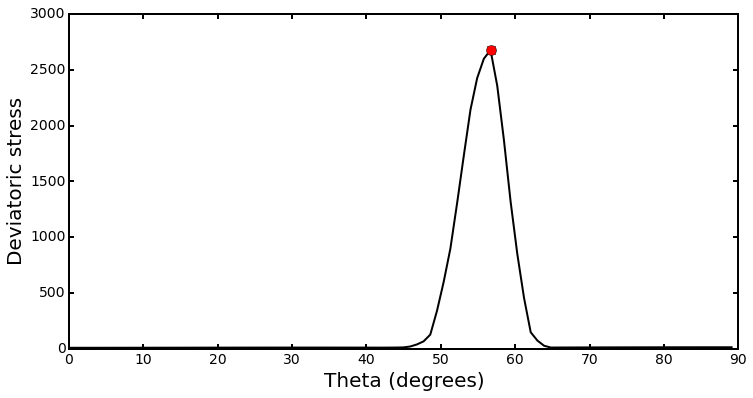

In [10]:
if((uw.nProcs()==1) and (uw.rank()==0)):
    %matplotlib inline
    pylab.rcParams['figure.figsize'] = 12, 6
    pylab.rcParams['xtick.major.size'] = 5
    pylab.rcParams['xtick.major.width'] = 2
    pylab.rcParams['xtick.minor.size'] = 3
    pylab.rcParams['xtick.minor.width'] = 2
    pylab.rcParams['ytick.major.size'] = 5
    pylab.rcParams['ytick.major.width'] = 2
    pylab.rcParams['ytick.minor.size'] = 3
    pylab.rcParams['ytick.minor.width'] = 2
    pylab.rcParams['axes.linewidth'] = 2
    pylab.rcParams['lines.linewidth'] = 2
    pylab.rcParams['xtick.labelsize'] = 14
    pylab.rcParams['ytick.labelsize'] = 14
    pylab.rcParams['lines.markersize'] = 10
    pyplot.plot(theta*180./np.pi, fdev, color = 'black') 
    pyplot.plot(thetamax*180./np.pi, fmax, 'ro')
    pyplot.xlabel('Theta (degrees)', fontsize=20)
    pyplot.ylabel('Deviatoric stress', fontsize=20)
    pyplot.show()